<a href="https://colab.research.google.com/github/lancedsouza/CNN/blob/main/CIFARipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transform
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Get the datatset
# Load CIFAR-10 datasets
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Wrap datasets in DataLoader (this is where num_workers and pin_memory go)
train_dataloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)
test_dataloader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)


100%|██████████| 170M/170M [00:12<00:00, 13.1MB/s]


In [3]:
len(trainset)

50000

In [4]:
image,label = trainset[1]
print(image.shape)
print(label)

torch.Size([3, 32, 32])
9


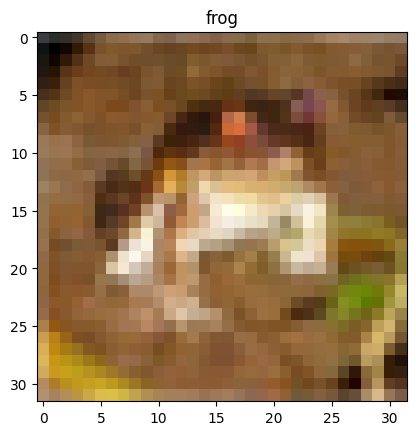

In [5]:

import matplotlib.pyplot as plt

# Define CIFAR-10 classes
classes = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

# Pick an image
image, label = trainset[0]

# Undo normalization ([-1,1] → [0,1]) and reorder for matplotlib
img_to_show = (image * 0.5 + 0.5).permute(1, 2, 0)

# Show
plt.imshow(img_to_show)
plt.title(classes[label])
plt.show()


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CIFAR10Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)

        # CIFAR-10: 32x32 → 16x16 → 8x8 → 4x4 after 3 pools
        self.linear1 = nn.Linear(128 * 4 * 4, 128)
        self.linear2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)

        x = F.relu(self.conv2(x))
        x = self.pool2(x)

        x = F.relu(self.conv3(x))
        x = self.pool3(x)

        x = x.view(x.size(0), -1)  # flatten
        x = F.relu(self.linear1(x))
        x = self.linear2(x)
        return x


In [7]:

model=CIFAR10Model().to('cuda')
loss_fn=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=0.001)



In [8]:
import time
device='cuda'
epochs=30

for epoch in range(epochs):
    start_time = time.time()
    model.train()
    running_loss = 0.0

    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}")

Epoch 1/30, Loss: 1.3828909397125244
Epoch 2/30, Loss: 0.8263832330703735
Epoch 3/30, Loss: 1.0249987840652466
Epoch 4/30, Loss: 0.4738802909851074
Epoch 5/30, Loss: 0.3419145345687866
Epoch 6/30, Loss: 0.7347927689552307
Epoch 7/30, Loss: 0.23744940757751465
Epoch 8/30, Loss: 0.5347861051559448
Epoch 9/30, Loss: 0.4346616864204407
Epoch 10/30, Loss: 0.3173956274986267
Epoch 11/30, Loss: 0.04210899397730827
Epoch 12/30, Loss: 0.048441942781209946
Epoch 13/30, Loss: 0.04605382680892944
Epoch 14/30, Loss: 0.009993183426558971
Epoch 15/30, Loss: 0.11871468275785446
Epoch 16/30, Loss: 0.15978077054023743
Epoch 17/30, Loss: 0.013666654005646706
Epoch 18/30, Loss: 0.052235350012779236
Epoch 19/30, Loss: 0.3039477467536926
Epoch 20/30, Loss: 0.02327815815806389
Epoch 21/30, Loss: 0.27799737453460693
Epoch 22/30, Loss: 0.012159657664597034
Epoch 23/30, Loss: 0.013490520417690277
Epoch 24/30, Loss: 0.15873223543167114
Epoch 25/30, Loss: 0.004166482947766781
Epoch 26/30, Loss: 0.0359620451927185

In [9]:
model.eval()
y_test=[]
y_pred=[]
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        y_test.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')




Accuracy of the network on the 10000 test images: 74 %


In [10]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.7434

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.79      0.79      1000
           1       0.83      0.88      0.86      1000
           2       0.73      0.58      0.64      1000
           3       0.50      0.64      0.56      1000
           4       0.74      0.65      0.69      1000
           5       0.65      0.63      0.64      1000
           6       0.81      0.79      0.80      1000
           7       0.78      0.80      0.79      1000
           8       0.84      0.86      0.85      1000
           9       0.82      0.81      0.81      1000

    accuracy                           0.74     10000
   macro avg       0.75      0.74      0.74     10000
weighted avg       0.75      0.74      0.74     10000


Confusion Matrix:
 [[793  21  36  22   7   5   9  12  61  34]
 [  9 882   8   8   4   3   9   3  23  51]
 [ 68   3 579 106  71  61  52  33  11  16]
 [ 17   8  37 642  45 136  44  41  13  17]
 [ 21  

Text(95.72222222222221, 0.5, 'True')

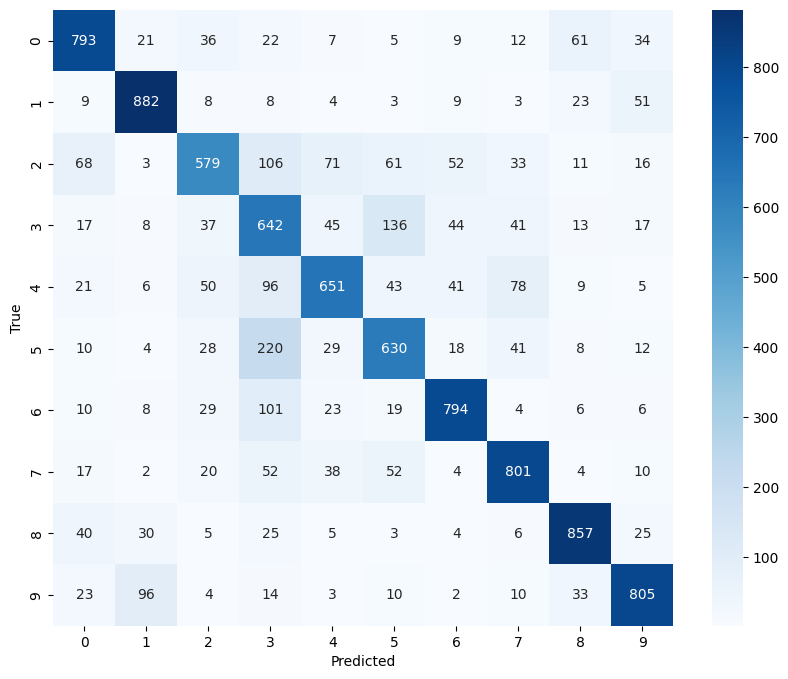

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')

Save the trained model

In [12]:
torch.save(model.state_dict(), "cifar_model.pth")


Later, reload it into the same model class:

In [13]:
model = CIFAR10Model()
model.load_state_dict(torch.load("cifar_model.pth", map_location=device))
model.to(device)
model.eval()


CIFAR10Model(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=2048, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=10, bias=True)
)

Define test transform

In [14]:
import torchvision.transforms as T
from PIL import Image

# CIFAR-10 classes
classes = ['airplane','automobile','bird','cat','deer',
           'dog','frog','horse','ship','truck']

test_transform = T.Compose([
    T.Resize((32, 32)),
    T.ToTensor(),
    T.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])


3. Load and test a single image

In [17]:
# Load the image
img = Image.open("/content/cat_image.jpg")

# Apply same transform as CIFAR test set
img_tensor = test_transform(img).unsqueeze(0).to(device)  # add batch dimension + move to GPU

# Predict
with torch.no_grad():
    outputs = model(img_tensor)
    _, predicted = torch.max(outputs, 1)

print("Predicted class:", classes[predicted.item()])


Predicted class: cat


In [19]:
import torchvision.datasets as datasets
import torchvision.transforms as T
from torch.utils.data import DataLoader

# Use the same test transform
test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=test_transform)

# Pick one sample
img, label = test_dataset[0]
img = img.unsqueeze(0).to(device)  # add batch dimension

with torch.no_grad():
    outputs = model(img)
    _, predicted = outputs.max(1)

print("Ground truth:", classes[label])
print("Predicted   :", classes[predicted.item()])


Ground truth: cat
Predicted   : cat
